# Expected Epidemic Size of Mask Model -- Multitypes

$P(A_{L, 0}) = f_0(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(A_{L, 1}) = f_1(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$M$ types of masks in total

$P(\text{not wear a mask(type-1)}) = m_1$

$P(\text{wear a type-1 mask}) = m_1$

$P(\text{wear a type-2 mask}) = m_2$

...

$P(\text{wear a type-M mask}) = m_{M}$

$\sum_{i=1}^{M} m_i = 1$


$A_{L, 1}$ := Node v becomes **active** at level L given he **doesn't wear** a mask

$A_{L, 2}$ := Node v becomes **active** at level L given he **wears** a type-1 mask

$A_{L, 3}$ := Node v becomes **active** at level L given he **wears** a type-2 mask

...

$A_{L, M}$ := Node v becomes **active** at level L given he **wears** a type-M mask




## 1. Condition on num of neighbors from lower level

**Assumption**: Same degree distribution for all types of nodes







$B_k$ := Node v has $k - 1$ lower level neighbors

$P(A_{L, i}) = \sum_{k = 0}^{\infty}{P(A_{L, i} | B_k) * P(B_k)}$

where

$i = 0,1$

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$


## 2. Condition on num of neighbors wearing different types of masks

$N_i$ := Num of neighbors wearing type-i masks, $i \in \{1, 2, ..., M\}$
 
$\textbf{N} = (N_1, N_2, ..., N_{M}) \sim \operatorname{Multinomial}\left(k - 1, \textbf{p}\right)$
 
where
$\textbf{p} = (m_1, m_2, ..., m_{M})$


$P(A_{L, i} | B_k) = \sum_{n_1 = 0}^{k - 1} \sum_{n_2 = 0}^{k - 1 - n_1} ... \sum_{n_{M - 1} = 0}^{k - 1 - (n_1 + ... + n_{M-2})}
P(A_{L, i} | B_k, \textbf{N} = (n_1, ..., n_{M})) * \frac{(k - 1)!}{n_1!n_2!...n_{M}!} * {m_1}^{n_1} * {m_2}^{n_2}  * ... * {m_{M}}^{n_{M}} $

where

$\sum_{i = 1}^{M}n_i = k - 1$

$\sum_{i = 1}^{M}m_i = 1$

## 3. Condition on num of active lower level neighbors

$I_i$ := $I_i$ of $k-1$ lower level neighbors active and wear type-i masks

$\textbf{I} = (I_1, I_2, ..., I_{M})$


$I_i \sim \operatorname{Binomial}\left(n_i, P(A_{L-1,i})\right)$, where $i \in \{1, 2, ..., M\}$


$ P(A_{L, i} | B_k, \textbf{N} = (n_1, n_2, ..., n_{M})) = \\ \sum_{k_1 = 0}^{n_1}\sum_{k_2=0}^{n_2} ...\sum_{k_{M}=0}^{n_{M}} P(A_{L, i} | B_k, \textbf{N} =  (n_1, n_2, ..., n_{M}), \textbf{I} = (k_1, k_2, ..., k_{M})) \\* \left(\begin{array}{c}
n_1 \\
k_1
\end{array}\right) \left(\begin{array}{c}
n_2 \\
k_2
\end{array}\right) ... \left(\begin{array}{c}
n_{M} \\
k_{M}
\end{array}\right) * \\ (P(A_{L-1, 1})^{k_1} * (1 - P(A_{L-1,2}))^{n_1 - k_1}) \\ * (P(A_{L-1, 2})^{k_2} * (1 - P(A_{L-1, 2}))^{n_2 - k_2}) \\ * ... \\* (P(A_{L-1, M})^{k_{M}} * (1 - P(A_{L-1, M}))^{n_{M} - k_{M}})$

## 4. $P(A_{L, i} | B_k, \textbf{N} =  (n_1, ..., n_{M}), \textbf{I} = (k_1, ..., k_{M})) $

$R$ := $ B_k, \textbf{N} =  (n_1, ..., n_{M}), \textbf{I} = (k_1, ..., k_{M})$

![Screen%20Shot%202020-10-25%20at%203.02.15%20PM.png](attachment:Screen%20Shot%202020-10-25%20at%203.02.15%20PM.png)


$P(A_{L,i} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v wears a mask} | R)$

$ = 1 - \Pi_{j = 1}^M(1 - Tji)^{k_j}$

T_mask1 : outward effeciency of masks

T_mask2 : inward effeciency of masks

# Prob of Emergence for Mask Model -- Multitypes


$M$ types of masks in total

$P(\text{not wear a mask(type-1)}) = m_1$

$P(\text{wear a type-1 mask}) = m_1$

$P(\text{wear a type-2 mask}) = m_2$

...

$P(\text{wear a type-M mask}) = m_{M}$

$\sum_{i=1}^{M} m_i = 1$


$E_{L, 1}$ := Following an edge, the probability of extinction at level $L$ given the node wears a **type-1** mask

$E_{L, 2}$ := Following an edge, the probability of extinction at level $L$ given the node wears a **type-2** mask

...

$E_{L, M}$ := Following an edge, the probability of extinction at level $L$ given the node wears a **type-M** mask





## 1. Condition on num of neighbors from lower level

**Assumption**: Same degree distribution for all types of nodes

$B_k$ := Node v has $k - 1$ lower level neighbors

$P(E_{L, i}) = \sum_{k = 0}^{\infty}{P(E_{L, i} | B_k) * P(B_k)}$

where

$i = 0,1$

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$



## 2. Condition on num of neighbors wearing different types of masks

$N_i$ := Num of neighbors wearing type-i masks, $i \in \{1, 2, ..., M\}$
 
$\textbf{N} = (N_1, N_2, ..., N_{M}) \sim \operatorname{Multinomial}\left(k - 1, \textbf{p}\right)$
 
where
$\textbf{p} = (m_1, m_2, ..., m_{M})$


$P(E_{L, i} | B_k) = \sum_{n_1 = 0}^{k - 1} \sum_{n_2 = 0}^{k - 1 - n_1} ... \sum_{n_{M - 1} = 0}^{k - 1 - (n_1 + ... + n_{M-2})}
P(E_{L, i} | B_k, \textbf{N} = (n_1, ..., n_{M})) * \frac{(k - 1)!}{n_1!n_2!...n_{M}!} * {m_1}^{n_1} * {m_2}^{n_2}  * ... * {m_{M}}^{n_{M}} $

where

$\sum_{i = 1}^{M}n_i = k - 1$

$\sum_{i = 1}^{M}m_i = 1$



## 3. Condition on num of active lower level neighbors

$I_i$ := $I_i$ of $k-1$ lower level neighbors active and wear type-i masks

$\textbf{I} = (I_1, I_2, ..., I_{M})$

If the **initial node** at level L wears **type-i** masks

$I_j \sim \operatorname{Binomial}\left(n_i, T_{i,j})\right)$, where $j \in \{1, 2, ..., M\}$


$ P(E_{L, i} | B_k, \textbf{N} = (n_1, n_2, ..., n_{M})) = \\ \sum_{k_1 = 0}^{n_1}\sum_{k_2=0}^{n_2} ...\sum_{k_{M}=0}^{n_{M}} P(A_{L, i} | B_k, \textbf{N} =  (n_1, n_2, ..., n_{M}), \textbf{I} = (k_1, k_2, ..., k_{M})) \\* \left(\begin{array}{c}
n_1 \\
k_1
\end{array}\right) \left(\begin{array}{c}
n_2 \\
k_2
\end{array}\right) ... \left(\begin{array}{c}
n_{M} \\
k_{M}
\end{array}\right) * \\ 
T_{i, 1}^{k_1} (1 - T_{i, 1})^{n_1 - k_1} P(E_{L + 1,1})^{k_1} \\
* T_{i, 2}^{k_2} * (1 - T_{i, 2})^{n_2 - k_2} P(E_{L + 1,2})^{k_2} \\
* ... \\
* T_{i, M}^{k_{M}} * (1 - T_{i, M})^{n_{M} - k_{M}} P(E_{L+1,M})^{k_M} $

In [1]:
from os import listdir
from os.path import isfile, join
import json
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson
from scipy.special import comb
from scipy import optimize 
import multiprocessing, time
from multiprocessing import Manager
from collections import defaultdict
import collections
import sys, os
sys.path.append(os.path.abspath("auxiliary_scripts/"))
from jupyter_aux import *

In [2]:
def get_processed_res(thr=0.05, n=5000, e=1000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=100, 
                         msg='0to3', time_exp='', modelname='',):
    
    res = load_sim_raw_results(n=n, e=e, 
                         m=m, T=T, 
                         tm1=tm1, tm2=tm2, 
                         checkpoint=checkpoint, 
                         msg=msg,
                         modelname=modelname,
                              time_exp=time_exp)
    
    res_list = process_raw(res['raw'], res['paras'], thr)
    
    return res_list, res['paras'], res['mdl']

# Outward effeciency / Inward effeciency which more important?


## Fix tm2, change tm1 for Mask/no mask

In [ ]:
m = [0.1, 0.9]
es_analysis_s0 = load_analysis_results(m=m, 
                                T=0.6, 
                                tm1=[0.3, 0.5], 
                                tm2=[0.2 ], 
                                itemname='es', 
                                msg='es_strategy0',)

# Strategy 0 to 3 

## Strategy 0 -- no one wears masks [0.0, 0.0, 1.0]

In [7]:
tm1 = [0.3, 0.5, 1]
tm2 = [0.2, 0.5, 1]

es_analysis_s0 = load_analysis_results(m=m_s0, 
                                T=0.6, 
                                tm1=tm1_s1, 
                                tm2=tm2_s1, 
                                itemname='es', 
                                msg='es_strategy0',)


m: [1.0]
T: 0.6
tm1: [1]
tm2: [1]
msg: es_strategy0
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:17
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/es_strategy0/m[1.0]_T0.60tm1,1_1.00_tm1,2_1.00/113017:17


In [8]:
m_s0=[1.0]
tm1_s1 = [1]
tm2_s1 = [1]
es_analysis_s0 = load_analysis_results(m=m_s0, 
                                T=0.6, 
                                tm1=tm1_s1, 
                                tm2=tm2_s1, 
                                itemname='es', 
                                msg='es_strategy0',)

pe_analysis_s0 = load_analysis_results(m=m_s0, 
                                T=0.6, 
                                tm1=tm1_s1, 
                                tm2=tm2_s1, 
                                itemname='pe', 
                                msg='pe_strategy0',)

m: [1.0]
T: 0.6
tm1: [1]
tm2: [1]
msg: es_strategy0
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:17
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/es_strategy0/m[1.0]_T0.60tm1,1_1.00_tm1,2_1.00/113017:17
m: [1.0]
T: 0.6
tm1: [1]
tm2: [1]
msg: pe_strategy0
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:19
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/pe_strategy0/m[1.0]_T0.60tm1,1_1.00_tm1,2_1.00/113017:19


In [9]:
sim0, paras0, mdl0 = get_processed_res(thr=0.05, n=5000, e=10000, 
                         m=[0.0,0.0,1.0], T=0.6, 
                         tm1=tm1, tm2=tm2, 
                         checkpoint=1000, 
                         msg='strategy0', modelname='mask',)

m: [0.0, 0.0, 1.0]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.2, 0.5, 1]
msg: strategy0
modelname: mask
itemname: es
change: 0
n: 5000
e: 10000
cp: 1000
time_exp:  
From output module
112920:59
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree3.0612244897959187/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree3.0612244897959187/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree3.0612244897959187/cp3
cp: 4
From output module
Experiment path: /mnt/hdd

cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.836734693877551/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.836734693877551/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.836734693877551/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.8367

cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.2244897959183674/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.2244897959183674/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.2244897959183674/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.2

cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.6326530612244898/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.6326530612244898/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.6326530612244898/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree1.6

cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree9.591836734693878/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree9.591836734693878/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree9.591836734693878/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree2.04

cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree3.4693877551020407/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree3.4693877551020407/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree3.4693877551020407/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree3.4

cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree4.6938775510204085/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree4.6938775510204085/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree4.6938775510204085/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss0/meandegree4.6

cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree0.6122448979591837/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree0.6122448979591837/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree0.6122448979591837/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree0.6

cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree5.918367346938775/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree5.918367346938775/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree5.918367346938775/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree5.9183

cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree7.142857142857143/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree7.142857142857143/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree7.142857142857143/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree7.1428

cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree4.6938775510204085/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree4.6938775510204085/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree4.6938775510204085/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss1/meandegree4.6

cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree6.122448979591837/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree6.122448979591837/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree6.122448979591837/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree6.1224

cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree8.775510204081632/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree8.775510204081632/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree8.775510204081632/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree8.7755

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree3.673469387755102/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree3.673469387755102/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree3.673469387755102/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree3.6734

cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree4.6938775510204085/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree4.6938775510204085/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree4.6938775510204085/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy0/m[0.0, 0.0, 1.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112920:59/ss2/meandegree9

## Strategy 1 -- All wears surgical masks

In [10]:
m_s1 = [1.0]

es_analysis_s1 = load_analysis_results(m=m_s1, 
                                T=0.6, 
                                tm1=[0.3], 
                                tm2=[0.2], 
                                itemname='es', 
                                msg='es_strategy1',)

pe_analysis_s1 = load_analysis_results(m=m_s1, 
                                T=0.6, 
                                tm1=[0.3], 
                                tm2=[0.2], 
                                itemname='pe', 
                                msg='pe_strategy1',)

m: [1.0]
T: 0.6
tm1: [0.3]
tm2: [0.2]
msg: es_strategy1
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:17
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/es_strategy1/m[1.0]_T0.60tm1,1_0.30_tm1,2_0.20/113017:17
m: [1.0]
T: 0.6
tm1: [0.3]
tm2: [0.2]
msg: pe_strategy1
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:19
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/pe_strategy1/m[1.0]_T0.60tm1,1_0.30_tm1,2_0.20/113017:19


In [11]:
sim1, paras1, mdl1 = get_processed_res(thr=0.05, n=5000, e=10000, 
                         m=[1.0, 0.0, 0.0], T=0.6, 
                         tm1=tm1, tm2=tm2, 
                         checkpoint=1000, 
                         msg='strategy1', modelname='mask',)

m: [1.0, 0.0, 0.0]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.2, 0.5, 1]
msg: strategy1
modelname: mask
itemname: es
change: 0
n: 5000
e: 10000
cp: 1000
time_exp:  
From output module
112923:12
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree3.0612244897959187/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree3.0612244897959187/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree3.0612244897959187/cp3
cp: 4
From output module
Experiment path: /mnt/hdd

cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.081632653061225/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.081632653061225/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.081632653061225/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.0816

cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.8979591836734695/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.8979591836734695/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.8979591836734695/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.8

cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.4897959183673475/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.4897959183673475/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.4897959183673475/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree4.4

cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree8.775510204081632/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree8.775510204081632/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree8.775510204081632/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree8.7755

cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree9.591836734693878/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree9.591836734693878/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree9.591836734693878/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree9.591

cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree10.0/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree6.530612244897959/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree6.530612244897959/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree6.530612244897959

cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree7.346938775510204/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree7.346938775510204/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree7.346938775510204/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss0/meandegree7.3469

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree9.795918367346939/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree9.795918367346939/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree9.795918367346939/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree9.7959

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree4.4897959183673475/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree4.4897959183673475/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree4.4897959183673475/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree4.4

cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree2.857142857142857/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree2.857142857142857/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree6.73469387755102/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree6.734

cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree6.530612244897959/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree6.530612244897959/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree6.530612244897959/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss1/meandegree6.5306

cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree0.40816326530612246/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree1.4285714285714286/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree1.4285714285714286/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree

cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree6.122448979591837/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree8.979591836734695/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree8.979591836734695/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree8.97

cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree3.2653061224489797/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree3.2653061224489797/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree3.2653061224489797/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree3.2

cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree7.142857142857143/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree7.142857142857143/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree7.142857142857143/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy1/m[1.0, 0.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/112923:12/ss2/meandegree7.1428

## Strategy 2 -- all wear cloth masks

In [12]:
m_s2 = [1.0]
es_analysis_s2 = load_analysis_results(m=m_s2, 
                                T=0.6, 
                                tm1=[0.5], 
                                tm2=[0.5], 
                                itemname='es', 
                                msg='es_strategy2',)

pe_analysis_s2 = load_analysis_results(m=m_s2, 
                                T=0.6, 
                                tm1=[0.5], 
                                tm2=[0.5], 
                                itemname='pe', 
                                msg='pe_strategy2',)

m: [1.0]
T: 0.6
tm1: [0.5]
tm2: [0.5]
msg: es_strategy2
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:17
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/es_strategy2/m[1.0]_T0.60tm1,1_0.50_tm1,2_0.50/113017:17
m: [1.0]
T: 0.6
tm1: [0.5]
tm2: [0.5]
msg: pe_strategy2
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:19
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/pe_strategy2/m[1.0]_T0.60tm1,1_0.50_tm1,2_0.50/113017:19


In [13]:
sim2, paras2, mdl2 = get_processed_res(thr=0.05, n=5000, e=10000, 
                         m=[0.0,1.0,0.0], T=0.6, 
                         tm1=tm1, tm2=tm2, 
                         checkpoint=1000, 
                         msg='strategy2', modelname='mask',)

m: [0.0, 1.0, 0.0]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.2, 0.5, 1]
msg: strategy2
modelname: mask
itemname: es
change: 0
n: 5000
e: 10000
cp: 1000
time_exp:  
From output module
113000:31
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree3.0612244897959187/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree3.0612244897959187/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree3.0612244897959187/cp3
cp: 4
From output module
Experiment path: /mnt/hdd

cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree6.122448979591837/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree6.122448979591837/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree6.122448979591837/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree6.122

cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree3.2653061224489797/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree3.2653061224489797/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree3.2653061224489797/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree3.2

cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree2.0408163265306123/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree2.0408163265306123/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree5.1020408163265305/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree5

cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree10.0/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree10.0/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree10.0/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree10.0/cp9
cp: 10
From output module
Experiment

cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree9.387755102040817/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree9.387755102040817/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree9.387755102040817/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss0/meandegree9.3877

cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree4.285714285714286/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree4.285714285714286/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree4.285714285714286/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree4.2857

cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree0.0/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree0.0/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree0.0/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree0.0/cp8
cp: 9
From output module
Experiment path

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree8.16326530612245/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree8.16326530612245/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree8.16326530612245/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree8.1632653

cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree3.8775510204081636/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree3.8775510204081636/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree3.8775510204081636/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss1/meandegree3.

cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree3.0612244897959187/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree3.0612244897959187/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree3.0612244897959187/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree3.0

cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree8.979591836734695/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree8.979591836734695/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree4.8979591836734695/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree4.8

cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree3.2653061224489797/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree7.551020408163265/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree7.551020408163265/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree7.5

cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree7.142857142857143/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree7.142857142857143/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree7.142857142857143/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy2/m[0.0, 1.0, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113000:31/ss2/meandegree7.142

## Strategy 3 -- half surgical half cloth

In [14]:
m_s3 = [0.5, 0.5]

es_analysis_s3 = load_analysis_results(m=m_s3, 
                                T=0.6, 
                                tm1=[0.3, 0.5], 
                                tm2=[0.2, 0.5], 
                                itemname='es', 
                                msg='es_strategy3',)
pe_analysis_s3 = load_analysis_results(m=m_s3, 
                                T=0.6, 
                                tm1=[0.3, 0.5], 
                                tm2=[0.2, 0.5], 
                                itemname='pe', 
                                msg='pe_strategy3',)

m: [0.5, 0.5]
T: 0.6
tm1: [0.3, 0.5]
tm2: [0.2, 0.5]
msg: es_strategy3
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:19
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/es_strategy3/m[0.5, 0.5]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50/113017:19
m: [0.5, 0.5]
T: 0.6
tm1: [0.3, 0.5]
tm2: [0.2, 0.5]
msg: pe_strategy3
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
113017:20
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/pe_strategy3/m[0.5, 0.5]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50/113017:20


In [15]:
sim3, paras3, mdl3 = get_processed_res(thr=0.05, n=5000, e=10000, 
                         m=[0.5,0.5,0.0], T=0.6, 
                         tm1=tm1, tm2=tm2, 
                         checkpoint=1000, 
                         msg='strategy3', modelname='mask',)

m: [0.5, 0.5, 0.0]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.2, 0.5, 1]
msg: strategy3
modelname: mask
itemname: es
change: 0
n: 5000
e: 10000
cp: 1000
time_exp:  
From output module
113002:03
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree3.0612244897959187/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree3.0612244897959187/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree3.0612244897959187/cp3
cp: 4
From output module
Experiment path: /mnt/hdd

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree0.6122448979591837/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree0.6122448979591837/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree0.6122448979591837/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree0.6

cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree4.4897959183673475/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree4.4897959183673475/cp7
cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree4.4897959183673475/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree4.4

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree3.2653061224489797/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree3.2653061224489797/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree3.2653061224489797/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree3.2

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree2.857142857142857/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree2.857142857142857/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree2.857142857142857/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree2.8571

cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree7.346938775510204/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree2.2448979591836737/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree2.2448979591836737/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss0/meandegree2.

cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree8.36734693877551/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree8.36734693877551/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree8.36734693877551/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree8.3673469

cp: 8
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree5.3061224489795915/cp8
cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree5.3061224489795915/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree5.3061224489795915/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree5

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree3.673469387755102/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree3.673469387755102/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree3.673469387755102/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree3.6734

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree7.142857142857143/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree7.142857142857143/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree7.142857142857143/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss1/meandegree7.1428

cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree1.4285714285714286/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree1.4285714285714286/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree1.4285714285714286/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree1.4

cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree4.8979591836734695/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree4.8979591836734695/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree4.8979591836734695/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree4.8

cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree7.551020408163265/cp4
cp: 5
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree7.551020408163265/cp5
cp: 6
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree7.551020408163265/cp6
cp: 7
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree7.5510

cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree3.8775510204081636/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree3.8775510204081636/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree3.8775510204081636/cp3
cp: 4
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/strategy3/m[0.5, 0.5, 0.0]_T0.60tm1,1_0.30_tm1,2_0.20tm2,1_0.50_tm2,2_0.50tm3,1_1.00_tm3,2_1.00/n5000_ttle10000/113002:03/ss2/meandegree3.8

## ES with AVG

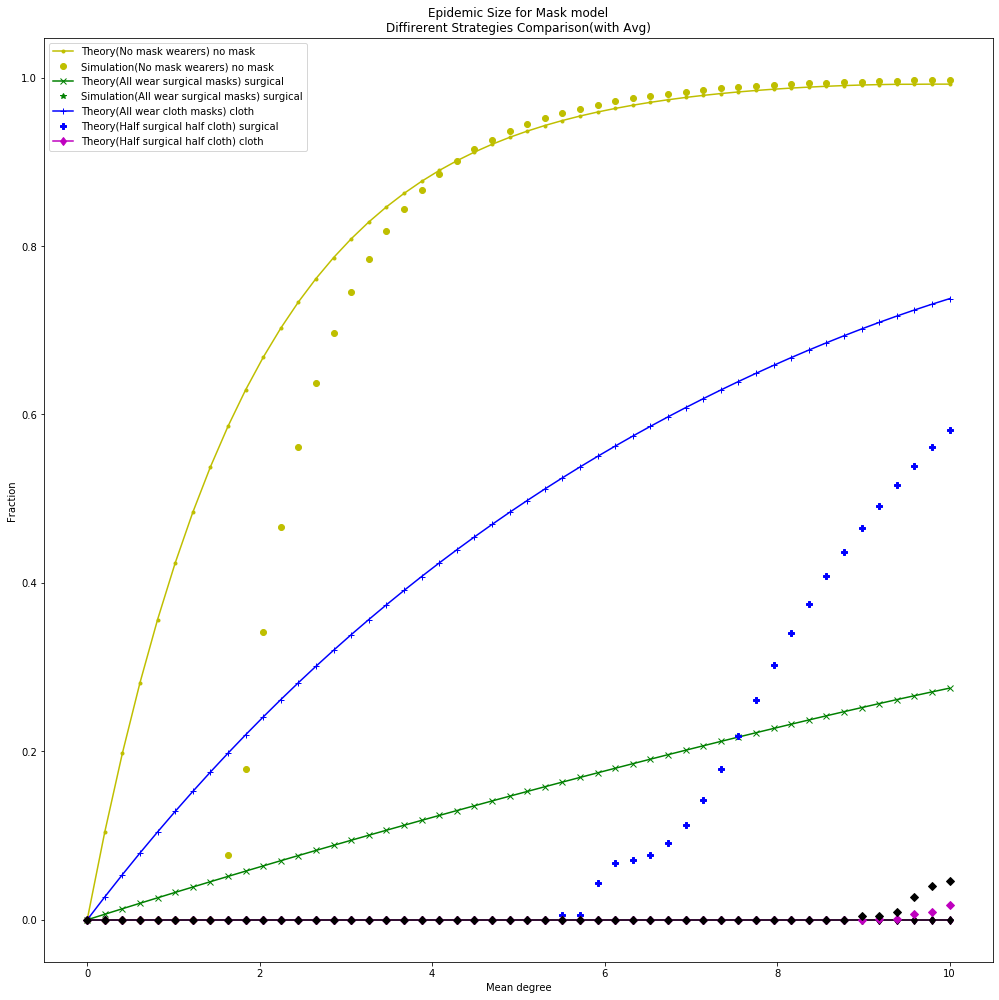

In [31]:
fig, ax = plt.subplots(figsize=(17,17))

ax.plot(es_analysis_s0['mdl'], np.array(es_analysis_s0['0']) * m_s0[0], 'y.-')
# ax.plot(es_analysis_s0['mdl'], np.array(es_analysis_s0['1']) * m_s0[1], 'b.-')
# ax.plot(es_analysis_s0['mdl'], np.array(es_analysis_s0['2']) * m_s0[2], 'y.-')
# ax.plot(es_analysis_s0['mdl'], np.array(es_analysis_s0['ttl']), 'r.-')


# ax.plot(mdl0, sim0[0]['es0'], 'go')
# ax.plot(mdl0, sim0[1]['es1'], 'bo')
ax.plot(mdl0, sim0[2]['es2'], 'yo')
# ax.plot(mdl0, sim0[2]['es'], 'ro')



ax.plot(es_analysis_s1['mdl'], np.array(es_analysis_s1['0']) * m_s1[0], 'g-x')
# ax.plot(es_analysis_s1['mdl'], np.array(es_analysis_s1['1']) * m_s1[1], 'b-x')
# ax.plot(es_analysis_s1['mdl'], np.array(es_analysis_s1['2']) * m_s1[2], 'y-x')
# ax.plot(es_analysis_s1['mdl'], np.array(es_analysis_s1['ttl']), 'r-x')

ax.plot(mdl1, sim1[0]['es0'], 'g*')
# ax.plot(mdl1, sim1[1]['es1'], 'b*')
# ax.plot(mdl1, sim1[2]['es2'], 'y*')
# ax.plot(mdl1, sim1[2]['es'], 'r*')

ax.plot(es_analysis_s2['mdl'], np.array(es_analysis_s2['0']) * m_s2[0], 'b+-')
# ax.plot(es_analysis_s2['mdl'], np.array(es_analysis_s2['1']) * m_s2[1], 'b+-')
# ax.plot(es_analysis_s2['mdl'], np.array(es_analysis_s2['2']) * m_s2[2], 'y+-')
# ax.plot(es_analysis_s2['mdl'], np.array(es_analysis_s2['ttl']), 'r+-')

# ax.plot(mdl2, sim2[0]['es0'], 'gP')
ax.plot(mdl2, sim2[1]['es1'], 'bP')
# ax.plot(mdl2, sim2[2]['es2'], 'yP')
# ax.plot(mdl2, sim2[1]['es'], 'rP')


ax.plot(es_analysis_s3['mdl'], np.array(es_analysis_s3['0']) * m_s3[0], 'md-')
ax.plot(es_analysis_s3['mdl'], np.array(es_analysis_s3['1']) * m_s3[1], 'kd-')
# ax.plot(es_analysis_s3['mdl'], np.array(es_analysis_s3['2']) * m_s3[2], 'yd-')
# ax.plot(es_analysis_s3['mdl'], np.array(es_analysis_s3['ttl']), 'rd-')


ax.plot(mdl3, sim3[0]['es0'], 'mD')
ax.plot(mdl3, sim3[1]['es1'], 'kD')
# ax.plot(mdl3, sim3[2]['es2'], 'yD')
# ax.plot(mdl3, sim3[1]['es'], 'rD')


ax.set_xlabel('Mean degree')
ax.set_ylabel('Fraction')

ax.set_title("Epidemic Size for Mask model\nDiffirerent Strategies Comparison(with Avg)")

legend_list = [
#                "Theory(No mask wearers) surgical",
#                "Theory(No mask wearers) cloth",
               "Theory(No mask wearers) no mask",
#                "Theory(No mask wearers) AVG",
               
#                "Simulation(No mask wearers) surgical",
#                "Simulation(No mask wearers) cloth",
               "Simulation(No mask wearers) no mask",
#                "Simulation(No mask wearers) AVG",
               
              "Theory(All wear surgical masks) surgical",
#                "Theory(All wear surgical masks) cloth",
#                "Theory(All wear surgical masks) no mask",
#                "Theory(All wear surgical masks) AVG",
               
               "Simulation(All wear surgical masks) surgical",
#                "Simulation(All wear surgical masks) cloth",
#                "Simulation(All wear surgical masks) no mask",
#                "Simulation(All wear surgical masks) AVG",
               
#               "Theory(All wear cloth masks) surgical",
              "Theory(All wear cloth masks) cloth",
#               "Theory(All wear cloth masks) no mask",
#                "Theory(All wear cloth masks) AVG",
                             
#                "Simulation(All wear cloth masks) surgical",
#               "Simulation(All wear cloth masks) cloth",
#               "Simulation(All wear cloth masks) no mask",
#                "Simulation(All wear cloth masks) AVG",
               
               "Theory(Half surgical half cloth) surgical",
              "Theory(Half surgical half cloth) cloth",
#               "Theory(Half surgical half cloth) no mask",
#               "Theory(Half surgical half cloth) AVG",
              
#               "Simulation(Half surgical half cloth) surgical",
#               "Simulation(Half surgical half cloth) cloth",
#               "Simulation(Half surgical half cloth) no mask",
#                "Simulation(Half surgical half cloth) AVG",
              ]
ax.legend(legend_list)

NameError: name 'mdl0' is not defined

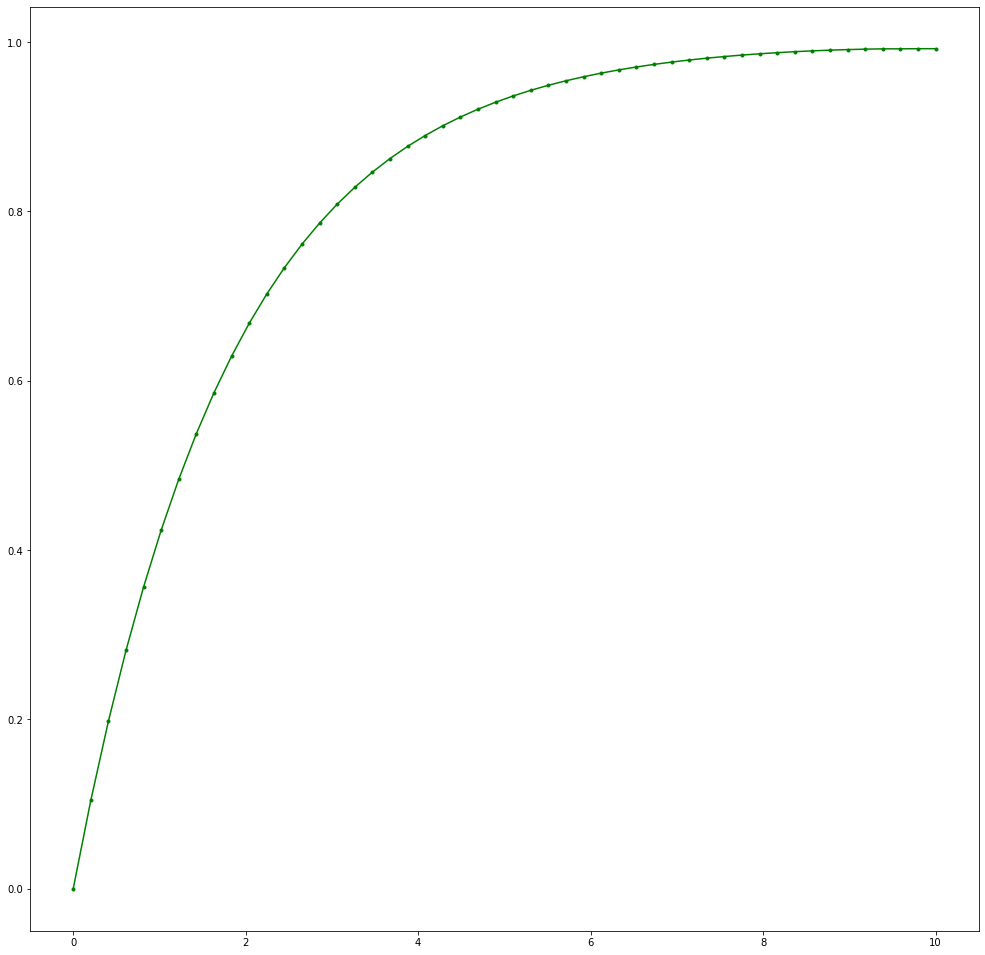

In [6]:
fig, ax = plt.subplots(figsize=(17,17))

ax.plot(es_analysis_s0['mdl'], np.array(es_analysis_s0['0']) * m_s0[0], 'g.-')
# ax.plot(es_analysis_s0['mdl'], np.array(es_analysis_s0['1']) * m_s0[1], 'b.-')
# ax.plot(es_analysis_s0['mdl'], np.array(es_analysis_s0['2']) * m_s0[2], 'y.-')
# ax.plot(es_analysis_s0['mdl'], np.array(es_analysis_s0['ttl']), 'r.-')


ax.plot(mdl0, sim0[0]['es0'], 'go')
ax.plot(mdl0, sim0[1]['es1'], 'bo')
# ax.plot(mdl0, sim0[2]['es2'], 'yo')
# ax.plot(mdl0, sim0[2]['es'], 'ro')



ax.plot(es_analysis_s1['mdl'], np.array(es_analysis_s1['0']) * m_s1[0], 'g-x')
# ax.plot(es_analysis_s1['mdl'], np.array(es_analysis_s1['1']) * m_s1[1], 'b-x')
# ax.plot(es_analysis_s1['mdl'], np.array(es_analysis_s1['2']) * m_s1[2], 'y-x')
# ax.plot(es_analysis_s1['mdl'], np.array(es_analysis_s1['ttl']), 'r-x')

ax.plot(mdl1, sim1[0]['es0'], 'g*')
ax.plot(mdl1, sim1[1]['es1'], 'b*')
# ax.plot(mdl1, sim1[2]['es2'], 'y*')
# ax.plot(mdl1, sim1[2]['es'], 'r*')

ax.plot(es_analysis_s2['mdl'], np.array(es_analysis_s2['0']) * m_s2[0], 'g+-')
# ax.plot(es_analysis_s2['mdl'], np.array(es_analysis_s2['1']) * m_s2[1], 'b+-')
# ax.plot(es_analysis_s2['mdl'], np.array(es_analysis_s2['2']) * m_s2[2], 'y+-')
# ax.plot(es_analysis_s2['mdl'], np.array(es_analysis_s2['ttl']), 'r+-')

ax.plot(mdl2, sim2[0]['es0'], 'gP')
ax.plot(mdl2, sim2[1]['es1'], 'bP')
ax.plot(mdl2, sim2[2]['es2'], 'yP')
# ax.plot(mdl2, sim2[1]['es'], 'rP')


ax.plot(es_analysis_s3['mdl'], np.array(es_analysis_s3['0']) * m_s3[0], 'gd-')
ax.plot(es_analysis_s3['mdl'], np.array(es_analysis_s3['1']) * m_s3[1], 'bd-')
# ax.plot(es_analysis_s3['mdl'], np.array(es_analysis_s3['2']) * m_s3[2], 'yd-')
# ax.plot(es_analysis_s3['mdl'], np.array(es_analysis_s3['ttl']), 'rd-')


ax.plot(mdl3, sim3[0]['es0'], 'gD')
ax.plot(mdl3, sim3[1]['es1'], 'bD')
# ax.plot(mdl3, sim3[2]['es2'], 'yD')
# ax.plot(mdl3, sim3[1]['es'], 'rD')


ax.set_xlabel('Mean degree')
ax.set_ylabel('Fraction')

ax.set_title("Epidemic Size for Mask model\nDiffirerent Strategies Comparison(NO Avg)")

legend_list = ["Theory(No mask wearers) surgical",
               "Theory(No mask wearers) cloth",
               "Theory(No mask wearers) no mask",
#                "Theory(No mask wearers) AVG",
               
               "Simulation(No mask wearers) surgical",
               "Simulation(No mask wearers) cloth",
               "Simulation(No mask wearers) no mask",
#                "Simulation(No mask wearers) AVG",
               
              "Theory(All wear surgical masks) surgical",
               "Theory(All wear surgical masks) cloth",
               "Theory(All wear surgical masks) no mask",
#                "Theory(All wear surgical masks) AVG",
               
               "Simulation(All wear surgical masks) surgical",
               "Simulation(All wear surgical masks) cloth",
               "Simulation(All wear surgical masks) no mask",
#                "Simulation(All wear surgical masks) AVG",
               
              "Theory(All wear cloth masks) surgical",
              "Theory(All wear cloth masks) cloth",
              "Theory(All wear cloth masks) no mask",
#                "Theory(All wear cloth masks) AVG",
                             
               "Simulation(All wear cloth masks) surgical",
              "Simulation(All wear cloth masks) cloth",
              "Simulation(All wear cloth masks) no mask",
#                "Simulation(All wear cloth masks) AVG",
               
               "Theory(Half surgical half cloth) surgical",
              "Theory(Half surgical half cloth) cloth",
              "Theory(Half surgical half cloth) no mask",
#               "Theory(Half surgical half cloth) AVG",
              
              "Simulation(Half surgical half cloth) surgical",
              "Simulation(Half surgical half cloth) cloth",
              "Simulation(Half surgical half cloth) no mask",
#                "Simulation(Half surgical half cloth) AVG",
              ]
ax.legend(legend_list)

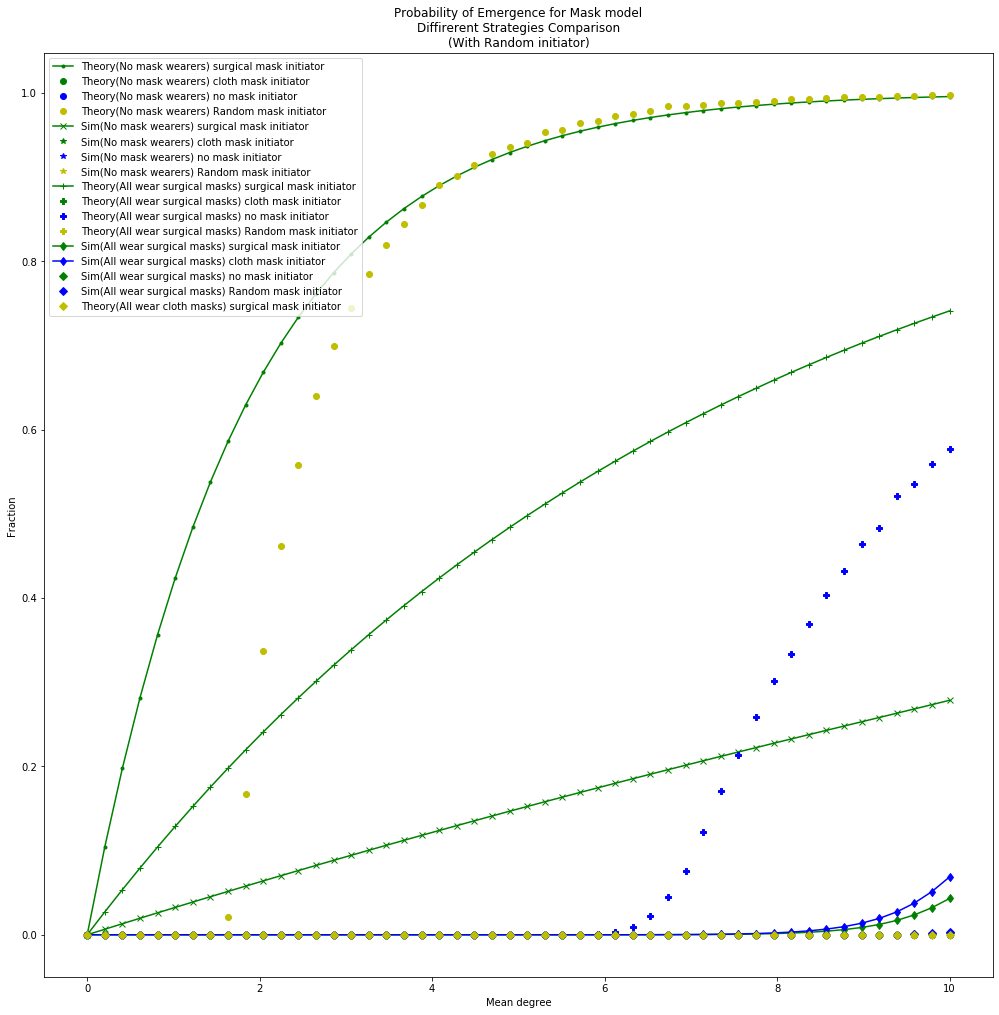

In [32]:
fig, ax = plt.subplots(figsize=(17,17))


ax.plot(pe_analysis_s0['mdl'], np.array(pe_analysis_s0['0']), 'g.-')
# ax.plot(pe_analysis_s0['mdl'], np.array(pe_analysis_s0['1']), 'b.-')
# ax.plot(pe_analysis_s0['mdl'], np.array(pe_analysis_s0['2']), 'y.-')
# ax.plot(pe_analysis_s0['mdl'], np.array(pe_analysis_s0['ttl']), 'r.-')

ax.plot(mdl0, sim0[0]['pe'], 'go')
ax.plot(mdl0, sim0[1]['pe'], 'bo')
ax.plot(mdl0, sim0[2]['pe'], 'yo')
# pe_random0 = np.array(sim0[0]['pe']) * m_s0[0] + np.array(sim0[1]['pe']) * m_s0[1] + np.array(sim0[2]['pe']) * m_s0[2]
# ax.plot(mdl0, pe_random0, 'ro')



ax.plot(pe_analysis_s1['mdl'], np.array(pe_analysis_s1['0']), 'gx-')
# ax.plot(pe_analysis_s1['mdl'], np.array(pe_analysis_s1['1']), 'bx-')
# ax.plot(pe_analysis_s1['mdl'], np.array(pe_analysis_s1['2']), 'yx-')
# ax.plot(pe_analysis_s1['mdl'], np.array(pe_analysis_s1['ttl']), 'rx-')

ax.plot(mdl1, sim1[0]['pe'], 'g*')
ax.plot(mdl1, sim1[1]['pe'], 'b*')
ax.plot(mdl1, sim1[2]['pe'], 'y*')
# pe_random1 = np.array(sim1[0]['pe']) * m_s1[0] +\
# np.array(sim1[1]['pe']) * m_s1[1] +\
# np.array(sim1[2]['pe']) * m_s1[2]

# ax.plot(mdl1, pe_random1, 'r*')


ax.plot(pe_analysis_s2['mdl'], np.array(pe_analysis_s2['0']), 'g+-')
# ax.plot(pe_analysis_s2['mdl'], np.array(pe_analysis_s2['1']), 'b+-')
# ax.plot(pe_analysis_s2['mdl'], np.array(pe_analysis_s2['2']), 'y+-')
# ax.plot(pe_analysis_s2['mdl'], np.array(pe_analysis_s2['ttl']), 'r+-')

ax.plot(mdl2, sim2[0]['pe'], 'gP')
ax.plot(mdl2, sim2[1]['pe'], 'bP')
ax.plot(mdl2, sim2[2]['pe'], 'yP')
# pe_random2 = np.array(sim2[0]['pe']) * m_s2[0] +\
# np.array(sim2[1]['pe']) * m_s2[1] +\
# np.array(sim2[2]['pe']) * m_s2[2]

# ax.plot(mdl2, pe_random2, 'rP')



ax.plot(pe_analysis_s3['mdl'], np.array(pe_analysis_s3['0']), 'gd-')
ax.plot(pe_analysis_s3['mdl'], np.array(pe_analysis_s3['1']), 'bd-')
# ax.plot(pe_analysis_s3['mdl'], np.array(pe_analysis_s3['2']), 'yd-')
# ax.plot(pe_analysis_s3['mdl'], np.array(pe_analysis_s3['ttl']), 'rd-')

ax.plot(mdl3, sim3[0]['pe'], 'gD')
ax.plot(mdl3, sim3[1]['pe'], 'bD')
ax.plot(mdl3, sim3[2]['pe'], 'yD')
# pe_random3 = np.array(sim3[0]['pe']) * m_s3[0] +\
# np.array(sim3[1]['pe']) * m_s3[1] +\
# np.array(sim3[2]['pe']) * m_s3[2]

# ax.plot(mdl3, pe_random3, 'rD')



ax.set_xlabel('Mean degree')
ax.set_ylabel('Fraction')

ax.set_title("Probability of Emergence for Mask model\nDiffirerent Strategies Comparison\n(With Random initiator)")

legend_list = ["Theory(No mask wearers) surgical mask initiator",
               "Theory(No mask wearers) cloth mask initiator",
               "Theory(No mask wearers) no mask initiator",
               "Theory(No mask wearers) Random mask initiator",
               
               "Sim(No mask wearers) surgical mask initiator",
               "Sim(No mask wearers) cloth mask initiator",
               "Sim(No mask wearers) no mask initiator",
               "Sim(No mask wearers) Random mask initiator",
               
               
              "Theory(All wear surgical masks) surgical mask initiator",
               "Theory(All wear surgical masks) cloth mask initiator",
               "Theory(All wear surgical masks) no mask initiator",
               "Theory(All wear surgical masks) Random mask initiator",
               
               "Sim(All wear surgical masks) surgical mask initiator",
               "Sim(All wear surgical masks) cloth mask initiator",
               "Sim(All wear surgical masks) no mask initiator",
               "Sim(All wear surgical masks) Random mask initiator",
               
              "Theory(All wear cloth masks) surgical mask initiator",
              "Theory(All wear cloth masks) cloth mask initiator",
              "Theory(All wear cloth masks) no mask initiator",
               "Theory(All wear cloth masks) Random mask initiator",
               
               "Sim(All wear cloth masks) surgical mask initiator",
              "Sim(All wear cloth masks) cloth mask initiator",
              "Sim(All wear cloth masks) no mask initiator",
               "Sim(All wear cloth masks) Random mask initiator",
               
               
               
               "Theory(Half surgical half cloth) surgical mask initiator",
              "Theory(Half surgical half cloth) cloth mask initiator",
              "Theory(Half surgical half cloth) no mask initiator",
              "Theory(Half surgical half cloth) Random mask initiator",
               
               "Sim(Half surgical half cloth) surgical mask initiator",
              "Sim(Half surgical half cloth) cloth mask initiator",
              "Sim(Half surgical half cloth) no mask initiator",
              "Sim(Half surgical half cloth) Random mask initiator",
              
              
              ]
ax.legend(legend_list)

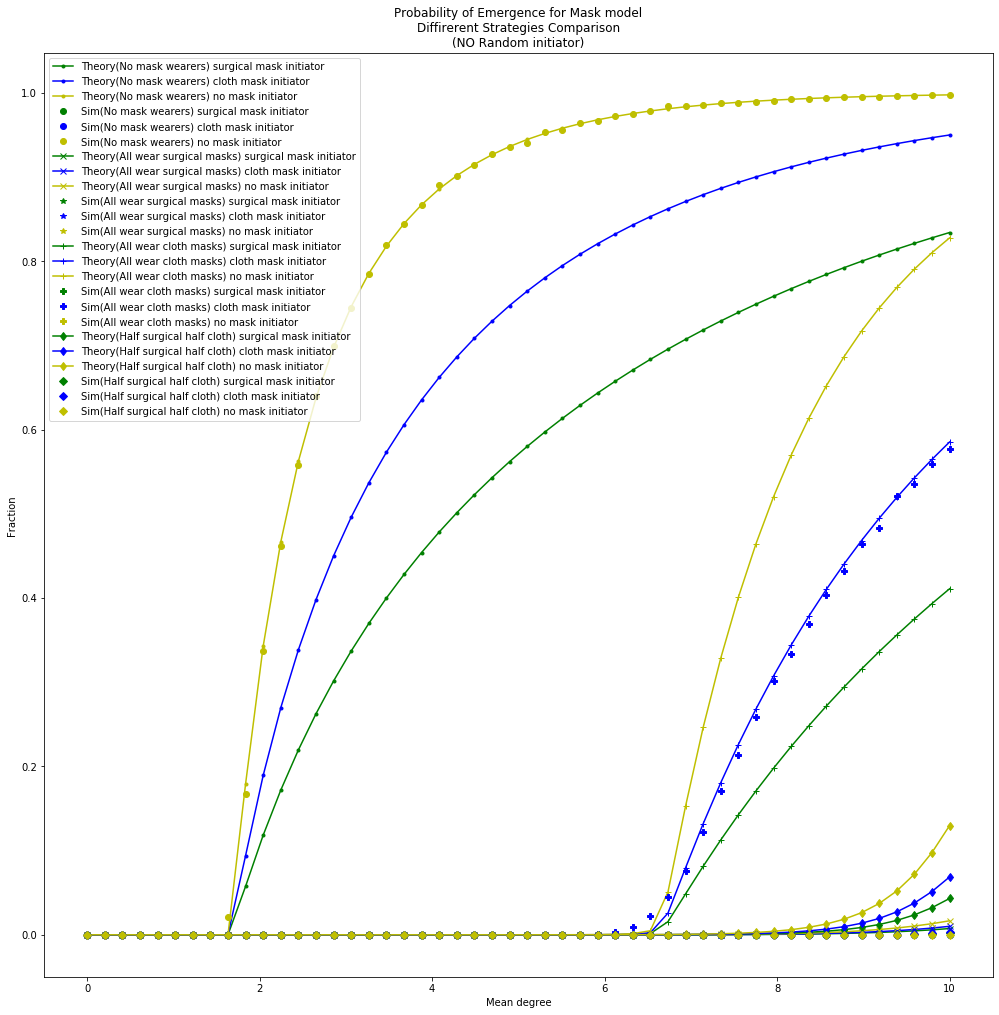

In [80]:
fig, ax = plt.subplots(figsize=(17,17))


ax.plot(pe_analysis_s0['mdl'], np.array(pe_analysis_s0['0']), 'g.-')
ax.plot(pe_analysis_s0['mdl'], np.array(pe_analysis_s0['1']), 'b.-')
ax.plot(pe_analysis_s0['mdl'], np.array(pe_analysis_s0['2']), 'y.-')
# ax.plot(pe_analysis_s0['mdl'], np.array(pe_analysis_s0['ttl']), 'r.-')

ax.plot(mdl0, sim0[0]['pe'], 'go')
ax.plot(mdl0, sim0[1]['pe'], 'bo')
ax.plot(mdl0, sim0[2]['pe'], 'yo')
pe_random0 = np.array(sim0[0]['pe']) * m_s0[0] + np.array(sim0[1]['pe']) * m_s0[1] + np.array(sim0[2]['pe']) * m_s0[2]
# ax.plot(mdl0, pe_random0, 'ro')



ax.plot(pe_analysis_s1['mdl'], np.array(pe_analysis_s1['0']), 'gx-')
ax.plot(pe_analysis_s1['mdl'], np.array(pe_analysis_s1['1']), 'bx-')
ax.plot(pe_analysis_s1['mdl'], np.array(pe_analysis_s1['2']), 'yx-')
# ax.plot(pe_analysis_s1['mdl'], np.array(pe_analysis_s1['ttl']), 'rx-')

ax.plot(mdl1, sim1[0]['pe'], 'g*')
ax.plot(mdl1, sim1[1]['pe'], 'b*')
ax.plot(mdl1, sim1[2]['pe'], 'y*')
pe_random1 = np.array(sim1[0]['pe']) * m_s1[0] +\
np.array(sim1[1]['pe']) * m_s1[1] +\
np.array(sim1[2]['pe']) * m_s1[2]

# ax.plot(mdl1, pe_random1, 'r*')


ax.plot(pe_analysis_s2['mdl'], np.array(pe_analysis_s2['0']), 'g+-')
ax.plot(pe_analysis_s2['mdl'], np.array(pe_analysis_s2['1']), 'b+-')
ax.plot(pe_analysis_s2['mdl'], np.array(pe_analysis_s2['2']), 'y+-')
# ax.plot(pe_analysis_s2['mdl'], np.array(pe_analysis_s2['ttl']), 'r+-')

ax.plot(mdl2, sim2[0]['pe'], 'gP')
ax.plot(mdl2, sim2[1]['pe'], 'bP')
ax.plot(mdl2, sim2[2]['pe'], 'yP')
pe_random2 = np.array(sim2[0]['pe']) * m_s2[0] +\
np.array(sim2[1]['pe']) * m_s2[1] +\
np.array(sim2[2]['pe']) * m_s2[2]

# ax.plot(mdl2, pe_random2, 'rP')



ax.plot(pe_analysis_s3['mdl'], np.array(pe_analysis_s3['0']), 'gd-')
ax.plot(pe_analysis_s3['mdl'], np.array(pe_analysis_s3['1']), 'bd-')
ax.plot(pe_analysis_s3['mdl'], np.array(pe_analysis_s3['2']), 'yd-')
# ax.plot(pe_analysis_s3['mdl'], np.array(pe_analysis_s3['ttl']), 'rd-')

ax.plot(mdl3, sim3[0]['pe'], 'gD')
ax.plot(mdl3, sim3[1]['pe'], 'bD')
ax.plot(mdl3, sim3[2]['pe'], 'yD')
pe_random3 = np.array(sim3[0]['pe']) * m_s3[0] +\
np.array(sim3[1]['pe']) * m_s3[1] +\
np.array(sim3[2]['pe']) * m_s3[2]

# ax.plot(mdl3, pe_random3, 'rD')



ax.set_xlabel('Mean degree')
ax.set_ylabel('Fraction')

ax.set_title("Probability of Emergence for Mask model\nDiffirerent Strategies Comparison\n(NO Random initiator)")

legend_list = ["Theory(No mask wearers) surgical mask initiator",
               "Theory(No mask wearers) cloth mask initiator",
               "Theory(No mask wearers) no mask initiator",
#                "Theory(No mask wearers) Random mask initiator",
               
               "Sim(No mask wearers) surgical mask initiator",
               "Sim(No mask wearers) cloth mask initiator",
               "Sim(No mask wearers) no mask initiator",
#                "Sim(No mask wearers) Random mask initiator",
               
               
              "Theory(All wear surgical masks) surgical mask initiator",
               "Theory(All wear surgical masks) cloth mask initiator",
               "Theory(All wear surgical masks) no mask initiator",
#                "Theory(All wear surgical masks) Random mask initiator",
               
               "Sim(All wear surgical masks) surgical mask initiator",
               "Sim(All wear surgical masks) cloth mask initiator",
               "Sim(All wear surgical masks) no mask initiator",
#                "Sim(All wear surgical masks) Random mask initiator",
               
              "Theory(All wear cloth masks) surgical mask initiator",
              "Theory(All wear cloth masks) cloth mask initiator",
              "Theory(All wear cloth masks) no mask initiator",
#                "Theory(All wear cloth masks) Random mask initiator",
               
               "Sim(All wear cloth masks) surgical mask initiator",
              "Sim(All wear cloth masks) cloth mask initiator",
              "Sim(All wear cloth masks) no mask initiator",
#                "Sim(All wear cloth masks) Random mask initiator",
               
               
               
               "Theory(Half surgical half cloth) surgical mask initiator",
              "Theory(Half surgical half cloth) cloth mask initiator",
              "Theory(Half surgical half cloth) no mask initiator",
#               "Theory(Half surgical half cloth) Random mask initiator",
               
               "Sim(Half surgical half cloth) surgical mask initiator",
              "Sim(Half surgical half cloth) cloth mask initiator",
              "Sim(Half surgical half cloth) no mask initiator",
#               "Sim(Half surgical half cloth) Random mask initiator",
              
              
              ]
ax.legend(legend_list)

# Check if ES for Mask Model

## Load Analysis

In [41]:
m = [0.45, 0.55]
sim_baseline, sim_baseline_paras, sim_baseline_mdl = get_processed_res(thr=0.05, n=5000, e=10, 
                         m=[0.45, 0.3, 0.25], T=0.6, 
                         tm1=[0.3, 0.5, 1], tm2=[0.7, 0.2, 1], 
                         checkpoint=5, 
                         msg='try_ratio_500', modelname='mask',)

m: [0.45, 0.3, 0.25]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.7, 0.2, 1]
msg: try_ratio_500
modelname: mask
itemname: es
change: 0
n: 5000
e: 10
cp: 5
time_exp:  
From output module
111715:29
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/try_ratio_500/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000_ttle10/111715:29/ss0/meandegree3.0612244897959187/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/try_ratio_500/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000_ttle10/111715:29/ss0/meandegree3.0612244897959187/cp2
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/try_ratio_500/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000_ttle10/111715:29/ss0/meandegree2.6530612244897958/cp1
cp: 2
From output module
Experiment path:

## Load zoomed in sim

m: [0.45, 0.3, 0.25]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.7, 0.2, 1]
msg: analysis4to6
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
111614:17
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/analysis4to6/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/111614:17


Text(0.5, 1.0, 'Epidemic Size for Mask model\nn5k_e100\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.05')

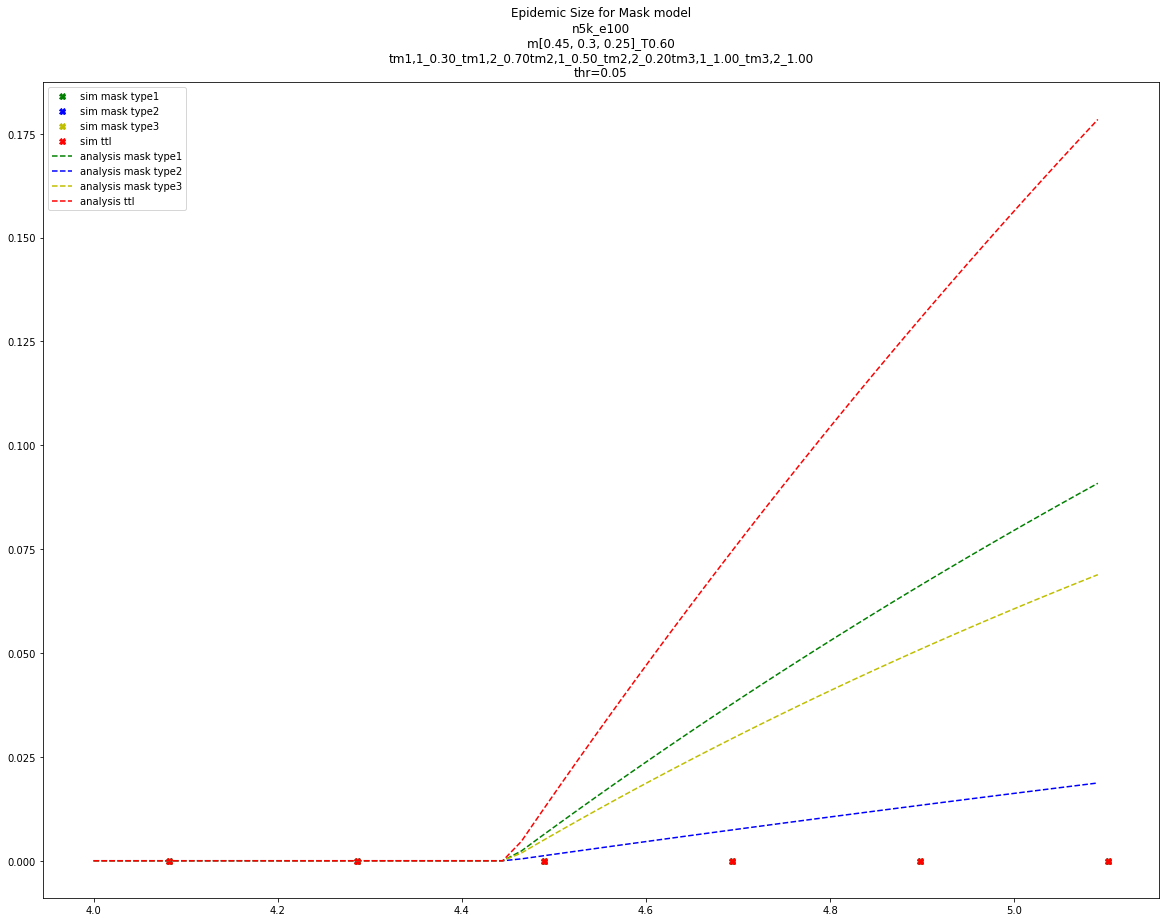

In [42]:
# try_sim, try_sim_paras, try_sim_mdl = get_processed_res(thr=0.05, n=1000, e=1000, 
#                          m=[0.45, 0.55], T=0.6, 
#                          tm1=[0.3, 1], tm2=[0.7, 1], 
#                          checkpoint=500, 
#                          msg='debug_sim_before3', modelname='mask',)
m=[0.45, 0.3, 0.25]
es_analysis_baseline = load_analysis_results(m=[0.45, 0.3, 0.25], 
                                T=0.6, 
                                tm1=[0.3, 0.5, 1], 
                                tm2=[0.7, 0.2, 1], 
                                itemname='es', 
                                msg='analysis4to6',)

fig, ax = plt.subplots(figsize=(20,15))
legend_list = []

# ax.plot(try_sim_mdl, try_sim[0]['es0'], 'x')
# ax.plot(try_sim_mdl, try_sim[0]['es1'], 'bx')
# ax.plot(try_sim_mdl, try_sim[0]['es'], 'rx')
start = 0
shift = 20
end = 55
shift2 = 29

ax.plot(sim_baseline_mdl[start + shift: end - shift2], sim_baseline[0]['es0'][start+ shift:end- shift2], 'gX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[0]['es1'][start+ shift:end- shift2], 'bX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[0]['es2'][start+ shift:end- shift2], 'yX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[0]['es'][start+ shift:end- shift2], 'rX')



ax.plot(es_analysis_baseline['mdl'][start:end], np.array(es_analysis_baseline['0'][start:end]) * m[0], 'g--')
ax.plot(es_analysis_baseline['mdl'][start:end], np.array(es_analysis_baseline['1'][start:end]) * m[1], 'b--')
ax.plot(es_analysis_baseline['mdl'][start:end], np.array(es_analysis_baseline['2'][start:end]) * m[2], 'y--')
ax.plot(es_analysis_baseline['mdl'][start:end], es_analysis_baseline['ttl'][start:end], 'r--')

ax.legend(['sim mask type1',
          'sim mask type2',
          'sim mask type3',
          'sim ttl',
          'analysis mask type1',
          'analysis mask type2',
          'analysis mask type3',
          'analysis ttl'])
ax.set_title("Epidemic Size for Mask model\nn5k_e100\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.05")

m: [0.45, 0.3, 0.25]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.7, 0.2, 1]
msg: 0to10_3_types
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
103121:33
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/0to10_3_types/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/103121:33


Text(0.5, 1.0, 'Epidemic Size for Mask model\nn5k_e10\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.05')

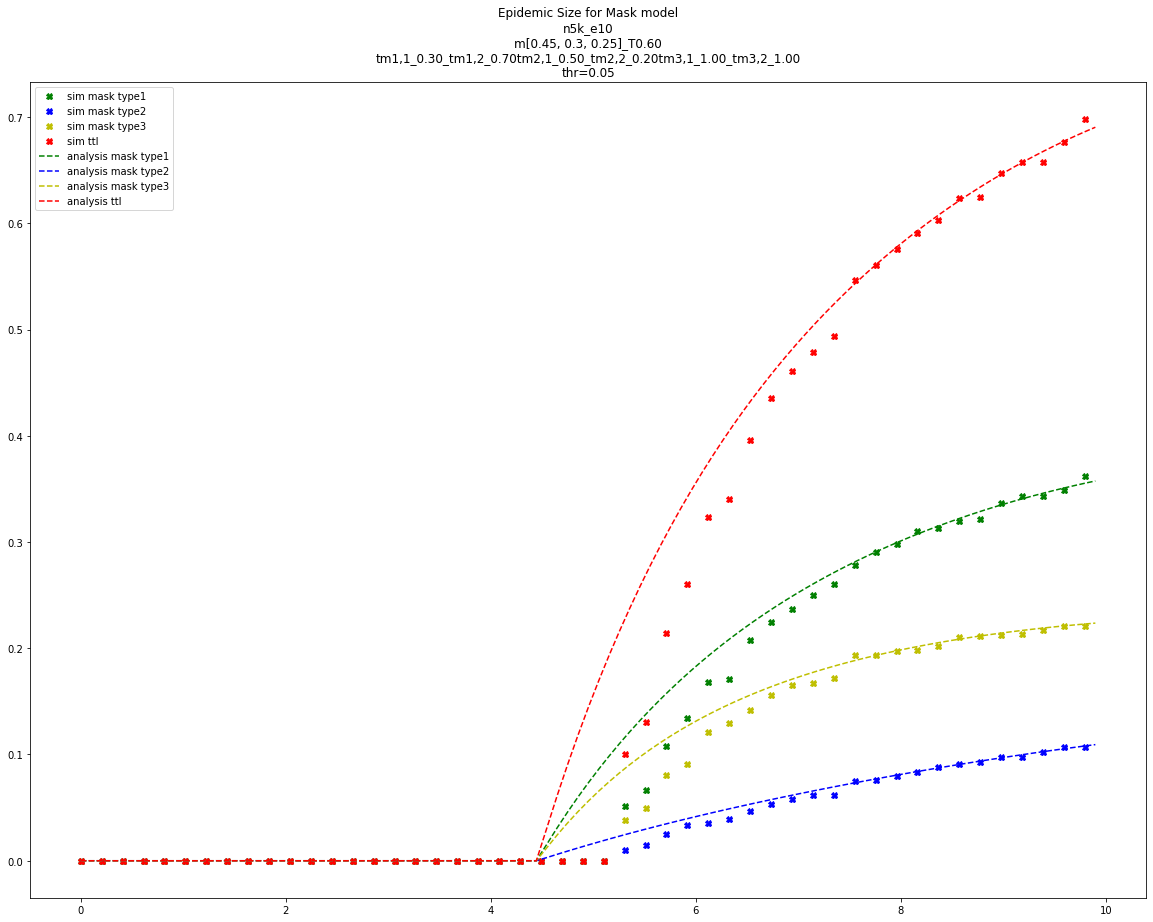

In [44]:
# try_sim, try_sim_paras, try_sim_mdl = get_processed_res(thr=0.05, n=1000, e=1000, 
#                          m=[0.45, 0.55], T=0.6, 
#                          tm1=[0.3, 1], tm2=[0.7, 1], 
#                          checkpoint=500, 
#                          msg='debug_sim_before3', modelname='mask',)
m=[0.45, 0.3, 0.25]
es_analysis_baseline = load_analysis_results(m=[0.45, 0.3, 0.25], 
                                T=0.6, 
                                tm1=[0.3, 0.5, 1], 
                                tm2=[0.7, 0.2, 1], 
                                itemname='es', 
                                msg='0to10_3_types',)

fig, ax = plt.subplots(figsize=(20,15))
legend_list = []

# ax.plot(try_sim_mdl, try_sim[0]['es0'], 'x')
# ax.plot(try_sim_mdl, try_sim[0]['es1'], 'bx')
# ax.plot(try_sim_mdl, try_sim[0]['es'], 'rx')
start = 0
shift = 0
end = -1
shift2 = 0

ax.plot(sim_baseline_mdl[start + shift: end - shift2], sim_baseline[0]['es0'][start+ shift:end- shift2], 'gX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[0]['es1'][start+ shift:end- shift2], 'bX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[0]['es2'][start+ shift:end- shift2], 'yX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[0]['es'][start+ shift:end- shift2], 'rX')



ax.plot(es_analysis_baseline['mdl'][start:end], np.array(es_analysis_baseline['0'][start:end]) * m[0], 'g--')
ax.plot(es_analysis_baseline['mdl'][start:end], np.array(es_analysis_baseline['1'][start:end]) * m[1], 'b--')
ax.plot(es_analysis_baseline['mdl'][start:end], np.array(es_analysis_baseline['2'][start:end]) * m[2], 'y--')
ax.plot(es_analysis_baseline['mdl'][start:end], es_analysis_baseline['ttl'][start:end], 'r--')

ax.legend(['sim mask type1',
          'sim mask type2',
          'sim mask type3',
          'sim ttl',
          'analysis mask type1',
          'analysis mask type2',
          'analysis mask type3',
          'analysis ttl'])
ax.set_title("Epidemic Size for Mask model\nn5k_e10\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.05")

# Check if mask PE still works

In [9]:
two_types_pe = load_analysis_results(m=[0.45, 0.55], 
                                T=0.6, 
                                tm1=[0.3, 1], 
                                tm2=[0.7, 1], 
                                itemname='pe', 
                                msg='beforechangepe',)

m: [0.45, 0.55]
T: 0.6
tm1: [0.3, 1]
tm2: [0.7, 1]
msg: beforechangepe
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
111615:15
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/beforechangepe/m[0.45, 0.55]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_1.00_tm2,2_1.00/111615:15


In [10]:
two_types_pe_changed = load_analysis_results(m=[0.45, 0.55], 
                                T=0.6, 
                                tm1=[0.3, 1], 
                                tm2=[0.7, 1], 
                                itemname='pe', 
                                msg='change_vec_pe',)

m: [0.45, 0.55]
T: 0.6
tm1: [0.3, 1]
tm2: [0.7, 1]
msg: change_vec_pe
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
111621:26
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/change_vec_pe/m[0.45, 0.55]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_1.00_tm2,2_1.00/111621:26


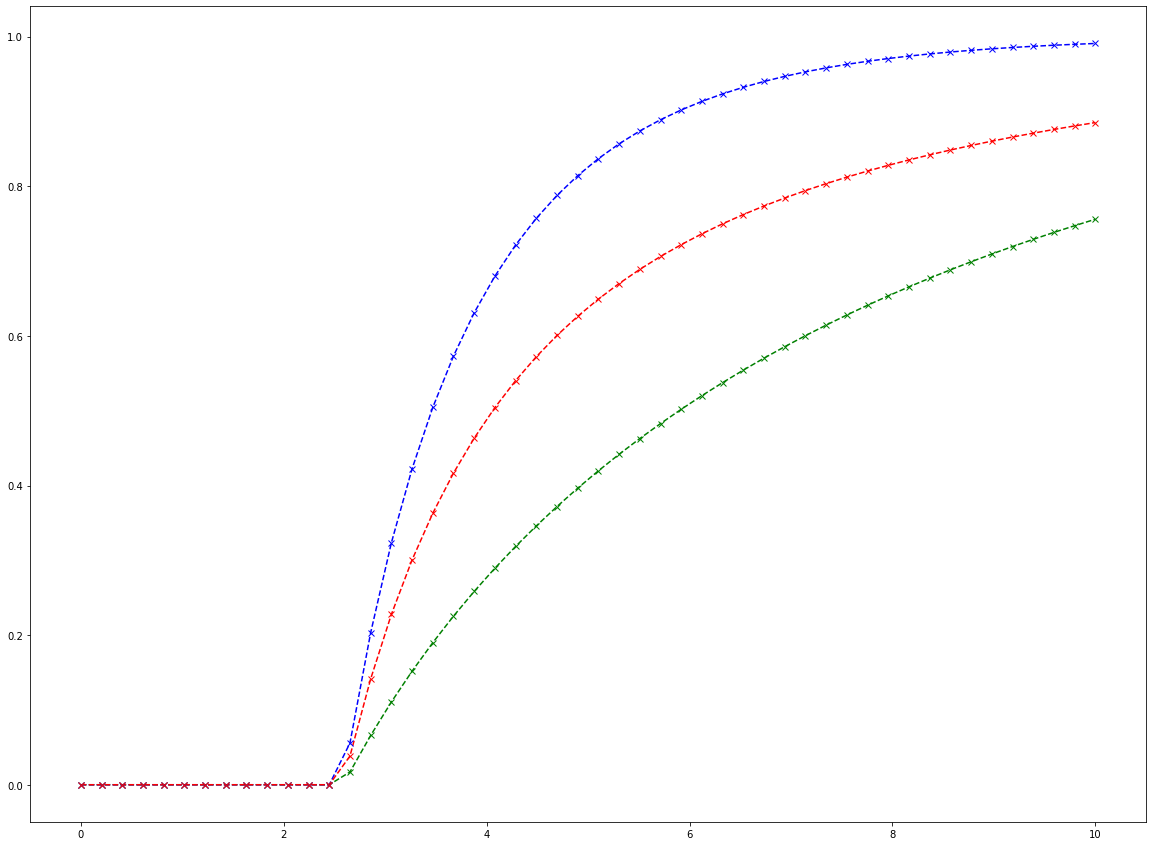

In [11]:
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(two_types_pe['mdl'], np.array(two_types_pe['0']) , 'g--')
ax.plot(two_types_pe['mdl'], np.array(two_types_pe['1']) , 'b--')
ax.plot(two_types_pe['mdl'], two_types_pe['ttl'], 'r--')

ax.plot(two_types_pe_changed['mdl'], np.array(two_types_pe_changed['0']) , 'gx')
ax.plot(two_types_pe_changed['mdl'], np.array(two_types_pe_changed['1']) , 'bx')
ax.plot(two_types_pe_changed['mdl'], two_types_pe_changed['ttl'], 'rx')

# Try 3 types of masks for PE analysis

In [12]:
m=[0.45, 0.3, 0.25]
pe_analysis_baseline = load_analysis_results(m=[0.45, 0.3, 0.25], 
                                T=0.6, 
                                tm1=[0.3, 0.5, 1], 
                                tm2=[0.7, 0.2, 1], 
                                itemname='pe', 
                                msg='pe_0_to_10_baseline',)

m: [0.45, 0.3, 0.25]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.7, 0.2, 1]
msg: pe_0_to_10_baseline
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
From output module
111621:41
From output module
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/pe_0_to_10_baseline/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/111621:41


In [21]:
sim_baseline, sim_baseline_paras, sim_baseline_mdl = get_processed_res(thr=0.04, n=5000000, e=1000, 
                         m=[0.45, 0.3, 0.25], T=0.6, 
                         tm1=[0.3, 0.5, 1], tm2=[0.7, 0.2, 1], 
                         checkpoint=100, 
                         msg='3tps_n5M_e1k_0to5', modelname='mask',)

m: [0.45, 0.3, 0.25]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.7, 0.2, 1]
msg: 3tps_n5M_e1k_0to5
modelname: mask
itemname: es
change: 0
n: 5000000
e: 1000
cp: 100
time_exp:  
From output module
111309:41
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/3tps_n5M_e1k_0to5/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000000_ttle1000/111309:41/ss0/meandegree4.375/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/3tps_n5M_e1k_0to5/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000000_ttle1000/111309:41/ss0/meandegree4.375/cp2
cp: 3
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/3tps_n5M_e1k_0to5/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000000_ttle1000/111309:41/ss0/meandegree4.375/cp3
cp: 4
From output module
Experiment path: 

cp: 9
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/3tps_n5M_e1k_0to5/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000000_ttle1000/111309:41/ss1/meandegree2.291666666666667/cp9
cp: 10
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/3tps_n5M_e1k_0to5/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000000_ttle1000/111309:41/ss1/meandegree2.291666666666667/cp10
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/3tps_n5M_e1k_0to5/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n5000000_ttle1000/111309:41/ss1/meandegree4.166666666666667/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/3tps_n5M_e1k_0to5/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.0

In [22]:
len(sim_baseline)

3

Text(0.5, 1.0, 'Probability for Mask model\nn5M_e1k\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.04')

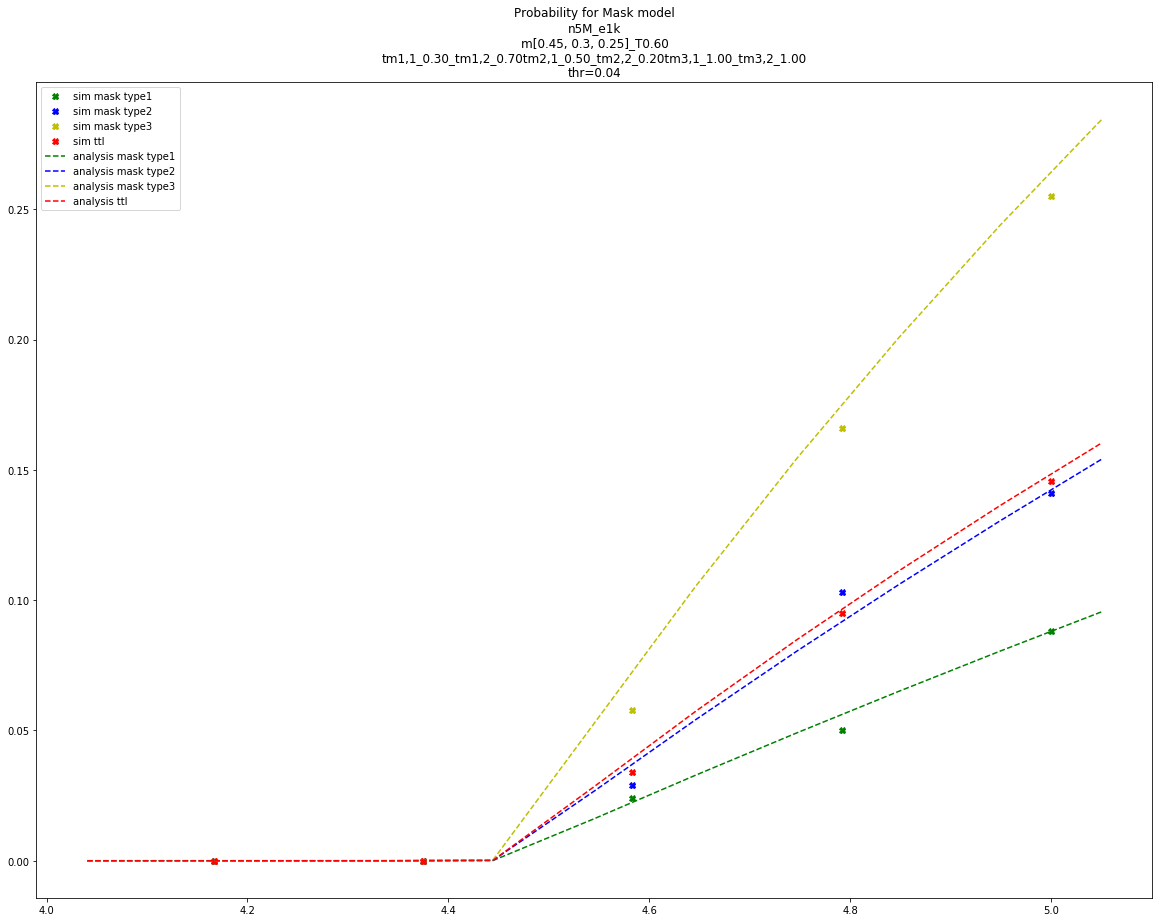

In [23]:
fig, ax = plt.subplots(figsize=(20,15))
legend_list = []

# ax.plot(try_sim_mdl, try_sim[0]['es0'], 'x')
# ax.plot(try_sim_mdl, try_sim[0]['es1'], 'bx')
# ax.plot(try_sim_mdl, try_sim[0]['es'], 'rx')
start = 40
shit = -20

ax.plot(sim_baseline_mdl[start + shit:], sim_baseline[0]['pe'][start + shit:], 'gX')
ax.plot(sim_baseline_mdl[start + shit:], sim_baseline[1]['pe'][start + shit:], 'bX')
ax.plot(sim_baseline_mdl[start + shit:], sim_baseline[2]['pe'][start + shit:], 'yX')

ax.plot(sim_baseline_mdl[start + shit:], np.array(sim_baseline[0]['pe'][start + shit:]) * m[0] + 
        np.array(sim_baseline[1]['pe'][start + shit:]) * m[1] + 
        np.array(sim_baseline[2]['pe'][start + shit:]) * m[2], 'rX')

end = 51

ax.plot(pe_analysis_baseline['mdl'][start:end], np.array(pe_analysis_baseline['0'][start:end]) , 'g--')
ax.plot(pe_analysis_baseline['mdl'][start:end], np.array(pe_analysis_baseline['1'][start:end]) , 'b--')
ax.plot(pe_analysis_baseline['mdl'][start:end], np.array(pe_analysis_baseline['2'][start:end]) , 'y--')
ax.plot(pe_analysis_baseline['mdl'][start:end], pe_analysis_baseline['ttl'][start:end], 'r--')

ax.legend(['sim mask type1',
          'sim mask type2',
          'sim mask type3',
          'sim ttl',
          'analysis mask type1',
          'analysis mask type2',
          'analysis mask type3',
          'analysis ttl'])
ax.set_title("Probability for Mask model\nn5M_e1k\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.04")

In [17]:
m = [0.45, 0.55]
sim_baseline, sim_baseline_paras, sim_baseline_mdl = get_processed_res(thr=0.03, n=50000, e=100, 
                         m=[0.45, 0.3, 0.25], T=0.6, 
                         tm1=[0.3, 0.5, 1], tm2=[0.7, 0.2, 1], 
                         checkpoint=50, 
                         msg='checkratio', modelname='mask',)

m: [0.45, 0.3, 0.25]
T: 0.6
tm1: [0.3, 0.5, 1]
tm2: [0.7, 0.2, 1]
msg: checkratio
modelname: mask
itemname: es
change: 0
n: 50000
e: 100
cp: 50
time_exp:  
From output module
111321:14
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/checkratio/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n50000_ttle100/111321:14/ss0/meandegree3.0612244897959187/cp1
cp: 2
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/checkratio/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n50000_ttle100/111321:14/ss0/meandegree3.0612244897959187/cp2
cp: 1
From output module
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/checkratio/m[0.45, 0.3, 0.25]_T0.60tm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00/n50000_ttle100/111321:14/ss0/meandegree2.6530612244897958/cp1
cp: 2
From output module
Experiment path: /m

Text(0.5, 1.0, 'Probability for Mask model\nn50k_e100\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.03')

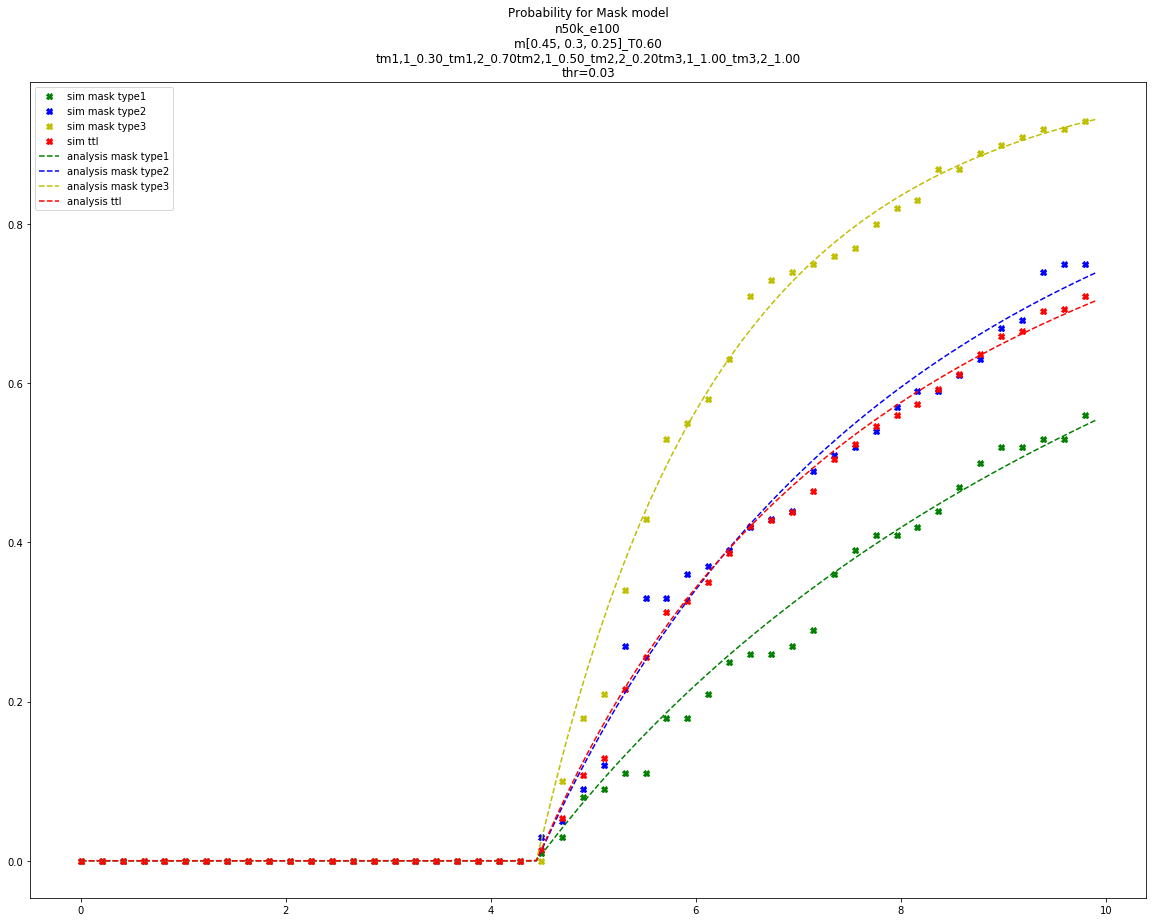

In [19]:
# try_sim, try_sim_paras, try_sim_mdl = get_processed_res(thr=0.05, n=1000, e=1000, 
#                          m=[0.45, 0.55], T=0.6, 
#                          tm1=[0.3, 1], tm2=[0.7, 1], 
#                          checkpoint=500, 
#                          msg='debug_sim_before3', modelname='mask',)
m=[0.45, 0.3, 0.25]


fig, ax = plt.subplots(figsize=(20,15))
legend_list = []

# ax.plot(try_sim_mdl, try_sim[0]['es0'], 'x')
# ax.plot(try_sim_mdl, try_sim[0]['es1'], 'bx')
# ax.plot(try_sim_mdl, try_sim[0]['es'], 'rx')
start = 0
shift = 0
end = -1
shift2 = 0

ax.plot(sim_baseline_mdl[start + shift: end - shift2], sim_baseline[0]['pe'][start+ shift:end- shift2], 'gX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[1]['pe'][start+ shift:end- shift2], 'bX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[2]['pe'][start+ shift:end- shift2], 'yX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], np.array(sim_baseline[0]['pe'][start+ shift:end- shift2]) * m[0] + 
        np.array(sim_baseline[1]['pe'][start+ shift:end- shift2]) * m[1] + 
        np.array(sim_baseline[2]['pe'][start+ shift:end- shift2]) * m[2], 'rX')



ax.plot(pe_analysis_baseline['mdl'][start+ shift * 2:end], np.array(pe_analysis_baseline['0'][start+ shift * 2:end]) , 'g--')
ax.plot(pe_analysis_baseline['mdl'][start+ shift* 2:end], np.array(pe_analysis_baseline['1'][start+ shift* 2:end]) , 'b--')
ax.plot(pe_analysis_baseline['mdl'][start+ shift* 2:end], np.array(pe_analysis_baseline['2'][start+ shift* 2:end]) , 'y--')
ax.plot(pe_analysis_baseline['mdl'][start+ shift* 2:end], pe_analysis_baseline['ttl'][start+ shift* 2:end], 'r--')

ax.legend(['sim mask type1',
          'sim mask type2',
          'sim mask type3',
          'sim ttl',
          'analysis mask type1',
          'analysis mask type2',
          'analysis mask type3',
          'analysis ttl'])
ax.set_title("Probability for Mask model\nn50k_e100\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.03")

Text(0.5, 1.0, 'Probability for Mask model\nn50k_e100\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.03')

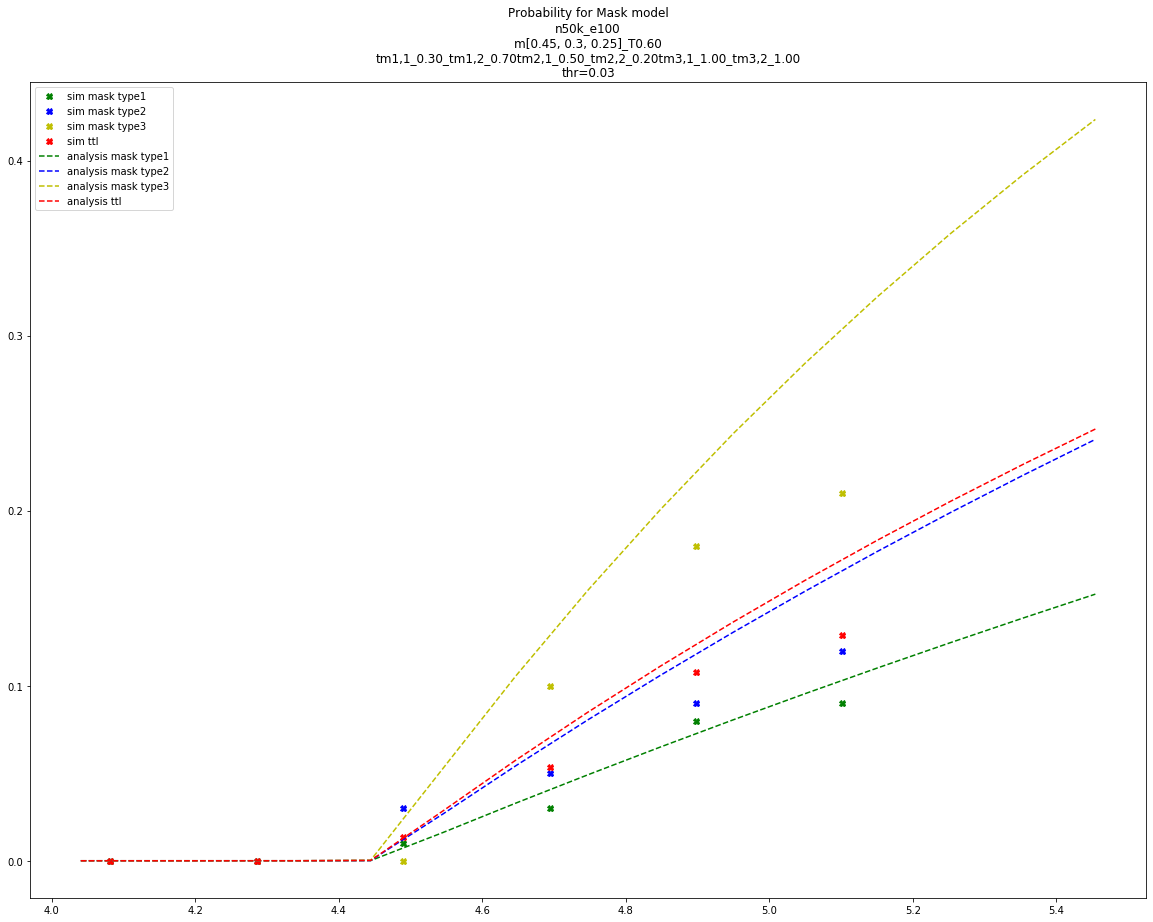

In [20]:
# try_sim, try_sim_paras, try_sim_mdl = get_processed_res(thr=0.05, n=1000, e=1000, 
#                          m=[0.45, 0.55], T=0.6, 
#                          tm1=[0.3, 1], tm2=[0.7, 1], 
#                          checkpoint=500, 
#                          msg='debug_sim_before3', modelname='mask',)
m=[0.45, 0.3, 0.25]


fig, ax = plt.subplots(figsize=(20,15))
legend_list = []

# ax.plot(try_sim_mdl, try_sim[0]['es0'], 'x')
# ax.plot(try_sim_mdl, try_sim[0]['es1'], 'bx')
# ax.plot(try_sim_mdl, try_sim[0]['es'], 'rx')
start = 0
shift = 20
end = 55
shift2 = 29

ax.plot(sim_baseline_mdl[start + shift: end - shift2], sim_baseline[0]['pe'][start+ shift:end- shift2], 'gX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[1]['pe'][start+ shift:end- shift2], 'bX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], sim_baseline[2]['pe'][start+ shift:end- shift2], 'yX')
ax.plot(sim_baseline_mdl[start + shift:end- shift2], np.array(sim_baseline[0]['pe'][start+ shift:end- shift2]) * m[0] + 
        np.array(sim_baseline[1]['pe'][start+ shift:end- shift2]) * m[1] + 
        np.array(sim_baseline[2]['pe'][start+ shift:end- shift2]) * m[2], 'rX')



ax.plot(pe_analysis_baseline['mdl'][start+ shift * 2:end], np.array(pe_analysis_baseline['0'][start+ shift * 2:end]) , 'g--')
ax.plot(pe_analysis_baseline['mdl'][start+ shift* 2:end], np.array(pe_analysis_baseline['1'][start+ shift* 2:end]) , 'b--')
ax.plot(pe_analysis_baseline['mdl'][start+ shift* 2:end], np.array(pe_analysis_baseline['2'][start+ shift* 2:end]) , 'y--')
ax.plot(pe_analysis_baseline['mdl'][start+ shift* 2:end], pe_analysis_baseline['ttl'][start+ shift* 2:end], 'r--')

ax.legend(['sim mask type1',
          'sim mask type2',
          'sim mask type3',
          'sim ttl',
          'analysis mask type1',
          'analysis mask type2',
          'analysis mask type3',
          'analysis ttl'])
ax.set_title("Probability for Mask model\nn50k_e100\nm[0.45, 0.3, 0.25]_T0.60\ntm1,1_0.30_tm1,2_0.70tm2,1_0.50_tm2,2_0.20tm3,1_1.00_tm3,2_1.00\nthr=0.03")